In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from datetime import datetime

# Config
plt.style.use("seaborn-v0_8")
sns.set_theme()
start_date = "2015-07-01"
end_date = "2025-07-31"
tickers = ["TSLA", "BND", "SPY"]

# Fetch data
data = {}
for ticker in tickers:
    df = yf.download(ticker, start=start_date, end=end_date)
    df.reset_index(inplace=True)
    data[ticker] = df
    print(f"{ticker} shape:", df.shape)

# Save raw data
for t, df in data.items():
    df.to_csv(f"data_raw_{t}.csv", index=False)


C:\Users\rebika\AppData\Local\Temp\ipykernel_12876\2804186158.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\rebika\AppData\Local\Temp\ipykernel_12876\2804186158.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\rebika\AppData\Local\Temp\ipykernel_12876\2804186158.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


TSLA shape: (2535, 6)
BND shape: (2535, 6)
SPY shape: (2535, 6)


In [3]:
for t, df in data.items():
    print(f"\n--- {t} ---")
    print(df.info())
    print(df.describe())
    print(f"Missing values:\n{df.isnull().sum()}")

    # Handle missing
    df.ffill(inplace=True)
    df.bfill(inplace=True)

    # Ensure date type
    df['Date'] = pd.to_datetime(df['Date'])

    # Sort by date
    df.sort_values("Date", inplace=True)

    data[t] = df



--- TSLA ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2535 entries, 0 to 2534
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   (Date, )        2535 non-null   datetime64[ns]
 1   (Close, TSLA)   2535 non-null   float64       
 2   (High, TSLA)    2535 non-null   float64       
 3   (Low, TSLA)     2535 non-null   float64       
 4   (Open, TSLA)    2535 non-null   float64       
 5   (Volume, TSLA)  2535 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 119.0 KB
None
Price                            Date        Close         High          Low  \
Ticker                                        TSLA         TSLA         TSLA   
count                            2535  2535.000000  2535.000000  2535.000000   
mean    2020-07-12 16:49:59.289940992   131.963002   134.960429   128.837831   
min               2015-07-01 00:00:00     9.578000    10.331333     

In [5]:
for t, df in data.items():
    price_col = 'Adj Close' if 'Adj Close' in df.columns else 'Close'
    df['Daily_Return'] = df[price_col].pct_change()
    df['Rolling_Mean'] = df[price_col].rolling(window=20).mean()
    df['Rolling_Std'] = df[price_col].rolling(window=20).std()
    data[t] = df


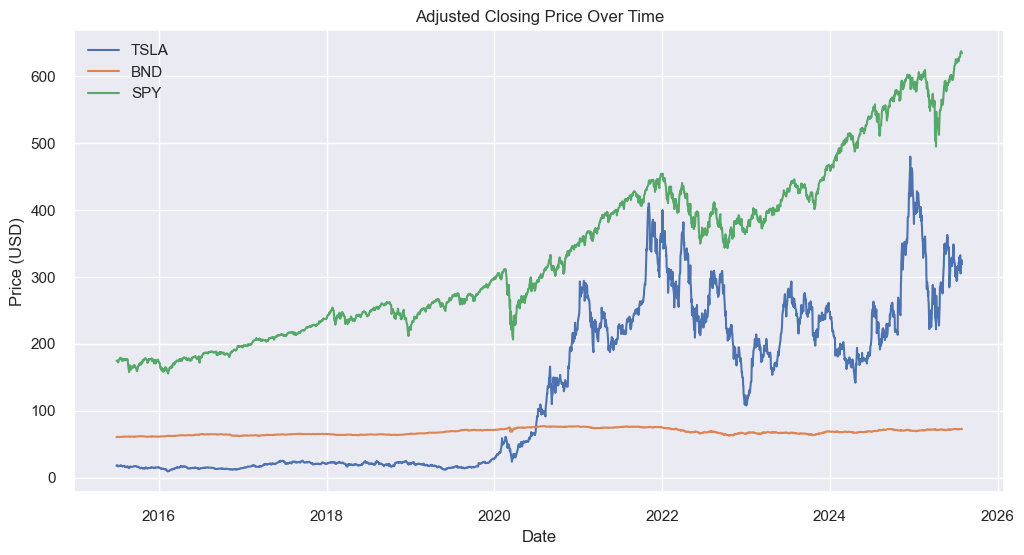

In [8]:
plt.figure(figsize=(12,6))

for t, df in data.items():
    # Find which column to use
    if 'Adj Close' in df.columns:
        price_col = 'Adj Close'
    elif 'Adj_Close' in df.columns:
        price_col = 'Adj_Close'
    elif 'Adjusted Close' in df.columns:
        price_col = 'Adjusted Close'
    else:
        price_col = 'Close'  # fallback
    
    plt.plot(df['Date'], df[price_col], label=t)

plt.title("Adjusted Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


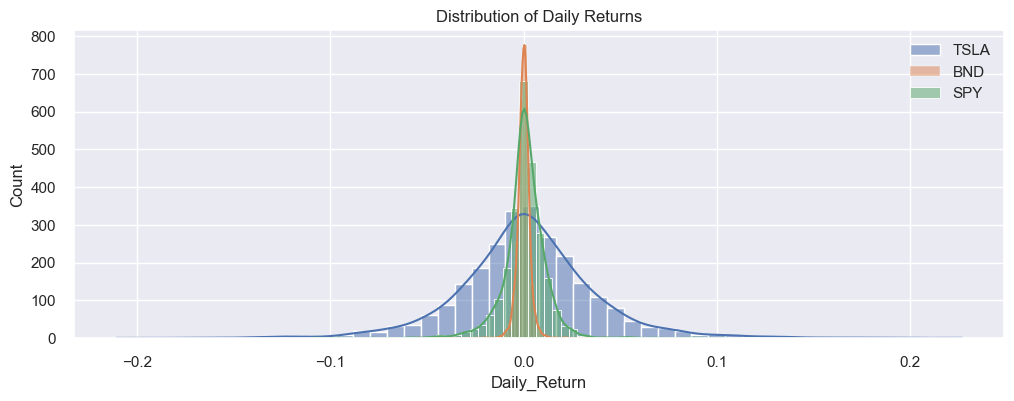

In [9]:
plt.figure(figsize=(12,4))
for t, df in data.items():
    sns.histplot(df['Daily_Return'].dropna(), kde=True, label=t, bins=50)
plt.legend()
plt.title("Distribution of Daily Returns")
plt.show()


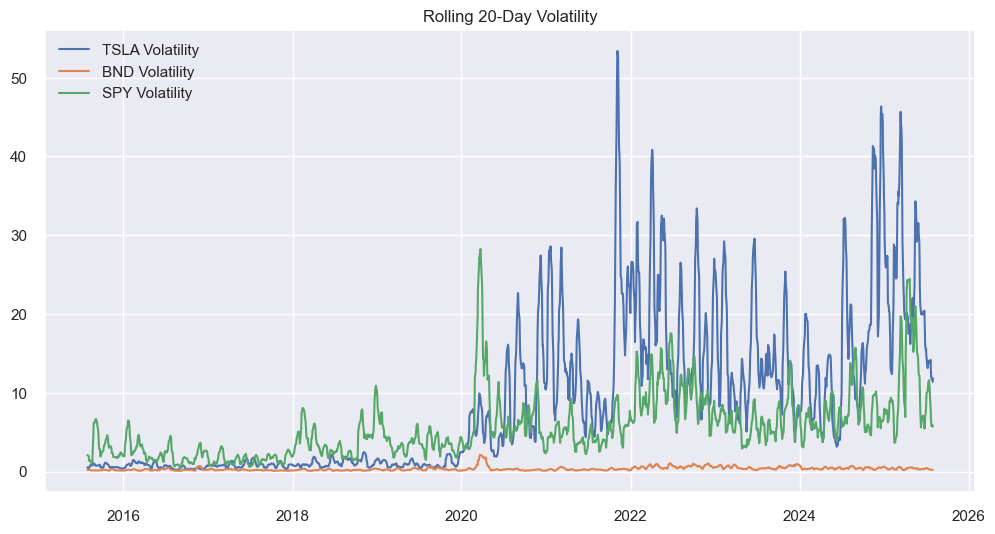

In [10]:
plt.figure(figsize=(12,6))
for t, df in data.items():
    plt.plot(df['Date'], df['Rolling_Std'], label=f"{t} Volatility")
plt.legend()
plt.title("Rolling 20-Day Volatility")
plt.show()


In [11]:
threshold = 0.05  # ±5% daily return
for t, df in data.items():
    outliers = df[(df['Daily_Return'] > threshold) | (df['Daily_Return'] < -threshold)]
    print(f"\n{t} Outlier Days:\n", outliers[['Date', 'Daily_Return']].head())



TSLA Outlier Days:
 Price        Date Daily_Return
Ticker                        
13     2015-07-21    -0.054879
25     2015-08-06    -0.088846
35     2015-08-20    -0.051205
37     2015-08-24    -0.051567
40     2015-08-27     0.080724

BND Outlier Days:
 Price        Date Daily_Return
Ticker                        
1182   2020-03-12    -0.054385

SPY Outlier Days:
 Price        Date Daily_Return
Ticker                        
878    2018-12-26     0.050525
1179   2020-03-09    -0.078094
1180   2020-03-10     0.051745
1182   2020-03-12    -0.095677
1183   2020-03-13     0.085486


In [13]:
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f"ADF Statistic for {title}: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    if result[1] <= 0.05:
        print("✅ Stationary")
    else:
        print("❌ Non-stationary")

for t, df in data.items():
    # Determine the correct price column
    if 'Adj Close' in df.columns:
        price_col = 'Adj Close'
    elif 'Adj_Close' in df.columns:
        price_col = 'Adj_Close'
    elif 'Adjusted Close' in df.columns:
        price_col = 'Adjusted Close'
    else:
        price_col = 'Close'

    adf_test(df[price_col], title=f"{t} Price")

    # Only run return test if column exists
    if 'Daily_Return' in df.columns:
        adf_test(df['Daily_Return'], title=f"{t} Return")
    else:
        print(f"⚠️ No Daily_Return column found for {t}")


ADF Statistic for TSLA Price: -1.4189
p-value: 0.5732
❌ Non-stationary
ADF Statistic for TSLA Return: -34.6811
p-value: 0.0000
✅ Stationary
ADF Statistic for BND Price: -1.5363
p-value: 0.5155
❌ Non-stationary
ADF Statistic for BND Return: -9.8898
p-value: 0.0000
✅ Stationary
ADF Statistic for SPY Price: 0.6908
p-value: 0.9897
❌ Non-stationary
ADF Statistic for SPY Return: -16.2644
p-value: 0.0000
✅ Stationary


In [14]:
risk_free_rate = 0.02 / 252  # daily risk-free rate

for t, df in data.items():
    mean_return = df['Daily_Return'].mean()
    std_dev = df['Daily_Return'].std()
    sharpe_ratio = (mean_return - risk_free_rate) / std_dev

    var_95 = np.percentile(df['Daily_Return'].dropna(), 5)

    print(f"\n--- {t} ---")
    print(f"Mean Daily Return: {mean_return:.4f}")
    print(f"Std Dev: {std_dev:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"95% VaR: {var_95:.4f}")



--- TSLA ---
Mean Daily Return: 0.0018
Std Dev: 0.0373
Sharpe Ratio: 0.0469
95% VaR: -0.0547

--- BND ---
Mean Daily Return: 0.0001
Std Dev: 0.0035
Sharpe Ratio: -0.0005
95% VaR: -0.0049

--- SPY ---
Mean Daily Return: 0.0006
Std Dev: 0.0115
Sharpe Ratio: 0.0431
95% VaR: -0.0172


In [15]:
for t, df in data.items():
    df.to_csv(f"data_clean_{t}.csv", index=False)
